# Image recorgition in pytorch using mnist DS

Epoch 1/3 - Loss: 0.4153
Epoch 2/3 - Loss: 0.1980
Epoch 3/3 - Loss: 0.1434
Training complete ✅ 2814


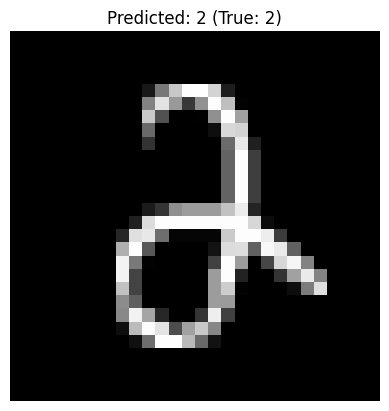

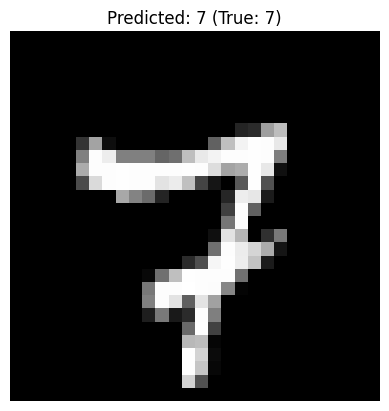

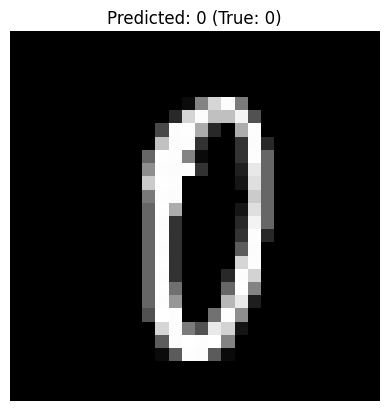

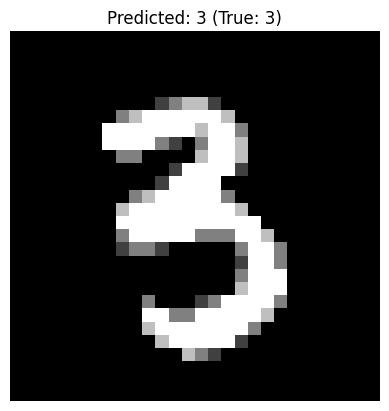

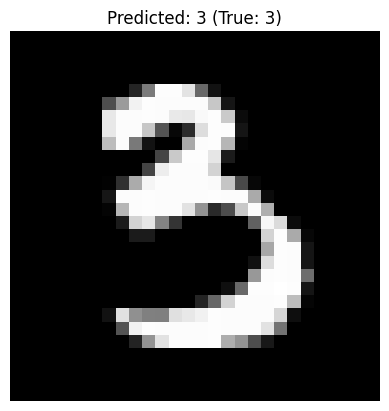

In [ ]:
import torch # import torch library
import torch.nn as nn # import nn module from torch library
import torch.optim as optim # import optim module from torch library to use optimizers
import torchvision # import torchvision library to use datasets and transforms (gets our mnist dataset)
import torchvision.transforms as transforms # import transforms module from torchvision library to use transforms (to transform the images to tensors and normalize them)

# 1. Load MNIST dataset
""" 
    Load MNIST dataset
        ↓
    Apply transform = transforms.Compose([...])
        ↓
    First Step: ToTensor()
        ↓
        - Converts each image into a Tensor.
        - Scales pixel values from [0, 255] → [0.0, 1.0].
        (Every pixel divided by 255 automatically.)
        - Changes shape: (28, 28) → (1, 28, 28)
        (adds a channel dimension for grayscale images.)

    Example:
        Original pixel (pure black) = 0 → 0.0
        Original pixel (pure white) = 255 → 1.0
        Original pixel (gray 128) ≈ 0.502

    Resulting Tensor Shape:
        (batch_size, 1, 28, 28)
        ↓
        
    Second Step: Normalize(mean=0.5, std=0.5)
        ↓
        - Shifts and scales values from [0, 1] → [-1, 1].
        - Formula: (pixel_value - mean) / std
        (pixel_value - 0.5) / 0.5

    Example:
        Pixel 0.0 → (0.0 - 0.5)/0.5 = -1.0  (black)
        Pixel 1.0 → (1.0 - 0.5)/0.5 = 1.0   (white)
        Pixel 0.5 → (0.5 - 0.5)/0.5 = 0.0   (gray)
        Pixel 0.61 → (0.61 - 0.5)/0.5 = 0.22 (gray)

    Why Normalize?
        - Makes training easier: neural networks work better when inputs are small and centered around 0.
        - Helps the model converge faster.

    Resulting Tensor Values:
        Range: [-1.0, 1.0]

        ↓
    Pass the normalized tensors into the Neural Network!
"""
transform = transforms.Compose([
    
    # this next TOtesnor dose 2 things 
    # it gets that first dimention the grayscale value of the pixel, each original images pixel is between 0 and 255 (0 black and 255 white) .ToTensor divides every pixel by 255 to get the value between 0 and 1 
    # it then convert images (28x28) to tensor of shape (1, 28, 28) meaning a 1x28x28 tensor. 28x28 pixels = 784 pixels with 1 channel (grayscale i.e black/white 1 or 0 or in between) which is what we did in the last line
    transforms.ToTensor(),  
    # in the next step we normalize our image. from the prevois step our greyscale value is between 0-1 but it can be any value between 0 and 1 by normalizing we convert this range [-1, 1] to make it easier for the model to learn
    # we always want some common small scale for all images to be between, usally centered around 0. in our case here we normalize to -1 and 1 so all images intensity values are between -1 and 1
    # meaning we want, black images (0) == -1 and white images (255) == 1 and grayscale images (128) == 0. we do this by subtracting the mean from the original value and dividing by the standard deviation 
    # thats why we use 0.5 and 0.5 as the mean and std for the images (this is a common value used in deep learning) this is done to normalize the image to a common scale, if we use 0.5 and 0.5 as the mean and std, a value between 0 and 1 will be between -1 and 1
    # Normalized-Value=Original Value−Mean/Standard Deviation. EX: black image (0 value after .ToTensor) -> (0-0.5)/0.5 = -1, white image (255 value after .ToTensor) -> (1-0.5)/0.5 = 1, grayscale image (128 value after .ToTensor) -> (0.5-0.5)/0.5 = 0
    # if the values in between: lets say after .ToTensor our pixel (156) then it will first be between 0 and 1, 156/255 = 0.61, now we normalize -> (0.61-0.5)/0.5 = 0.22, so we get a value of 0.22 which is between -1 and 1 (normalized), so we can use this value to represent the pixel in the image
    # we do this so that we can train our model faster and more accurately because the model has to deal with a smaller range, it also helps gradient descent and prevents bias in the model towards larger values. it also helps the model update the weights and biases faster and more accurately
    # NOTE: the last step is to place this normalized value in place of the old pixels values and construct the 1x28x28 image with the normalized values.
    # so it will look like: a 3d tensor but since the color channel is 1 its just a 2d tensor with 28 rows and 28 columns and 1 dimension for the color channel so it still looks like a 2d tensor .wrapped in some extra brackets all inside the tensor()
    # tensor([[[-1.0, -1.0, -1.0, ..., -1.0, -1.0, -1.0],
    #          [-1.0, -1.0, -1.0, ..., -1.0, -1.0, -1.0],
    #         [-1.0, -0.23, 0.22, ..., 0.23, -0.11, -1.0],
    #         ...,
    #         [-1.0, -1.0, -1.0, ..., -1.0, -1.0, -1.0]]])
    transforms.Normalize((0.5,), (0.5,))  # normalize to [-1,1] and mean=0.5 and std=0.5
])

# 2. Load the dataset (one for training and one for testing we use 2 so that the model sees unseen data and can generalize better)
""" 
    Step 1: Load Training and Test Data
        ↓
    Use torchvision.datasets.MNIST()
        ↓
        - Downloads the MNIST dataset (handwritten digits 0-9) if not already available.
        - `train=True`: load 60,000 training images.
        - `train=False`: load 10,000 testing images.
        - Applies the `transform` (ToTensor + Normalize) we defined earlier.

    Dataset structure after loading:
        - Each sample = (image, label)
        - `image`: 28x28 normalized tensor (single-channel grayscale image)
        - `label`: integer (0-9) — the actual digit.

        ↓

    Step 2: Create DataLoaders
        ↓
    Use torch.utils.data.DataLoader()
        ↓
        - Breaks the dataset into small batches (mini-batches) for training/testing.
        - Helps iterate over the dataset efficiently.
        - Avoids loading entire data into memory at once (memory-efficient).

    Parameters:
        - `batch_size=64` → 64 images per batch (training).
        - `batch_size=1` → 1 image per batch (testing).
        - `shuffle=True` → randomizes the data order every epoch (important to prevent overfitting).

    How the DataLoader outputs look:
        - Each batch: (batch_images, batch_labels)
        - batch_images: Tensor of shape (batch_size, 1, 28, 28)
        - batch_labels: Tensor of shape (batch_size,)
        
        ↓

    Usally we keep the test set separate from the training set so that we can test the model on unseen data and see how well it generalizes to new data. this is important because we want to see if the model can predict the labels of new data that it has not seen before.
    in our case since the mnist is 60000 and our trainset is also 60000 we still achive randomness from some 10000 picked images from the 60000 mnist has because we shuffle on so the train set and test set seem random
    Now ready to train and test the model!
"""
# in the 2 ex's below we first load the data and then pass that training data into a data loader which is a way to iterate over the data in batches
# for ex the mnist Data set loads a lot of data so we want to load it in batches and feed our model in batches that way we don't have to load the whole dataset into memory
# the MNIST dataset has a total of 60k images, but we use only 64 images at a time to train the model (this is called batch size and it prevents too many images from being loaded into memory at once) and we shuffle the data every epoch (this is done to prevent overfitting) 
# the loded data looks like: (data, labels) where data = tensor([[0, 0, 0.1, ...], [0, 0, 0.1, ...] ....]) a 28x28 matrix of images and labels = tensor([0, 1, 2, ...]) a 1d tensor of labels (0-9) for the images. each image has a label (0-9) for the digit in the image
# so the set of data which is the images and labels is passed to the loader which loads the data in baches of 64 images at a time and shuffles the data every epoch
# the loadder itself is a iterable with the form image, lable where each image (a 28x28 normalized matrix) would have a corresponding label (0-9) for the digit in the image. so we can use this to train our model
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform) # download=True will download the dataset if not already present in the data folder
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True) # batch_size=64 means that we will train on 64 images at a time and shuffle=True means that we will shuffle the images every epoch

testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform) # we load into the data folder the mnist dataset (a dataset of handwritten digits 0-9)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=True)  # batch_size=1 for one image at a time and shuffle=True

# 3. Define a simple NN
""" 
    Input (batch_size, 28, 28)   
    # (batch of images, each 28x28 pixels)

            ↓ (Flatten with .view())   
            # Using x = x.view(-1, 28*28)
            # Converts each 2D image into a 1D vector.
            
    (batch_size, 784)   
    # Now each image is a vector of 784 pixels.

            ↓ (Linear Layer: 784 → 128)   
            # First layer: Applies weights and biases.
            # Each of the 784 inputs is connected to each of the 128 neurons.
            # Weights are applied here**.
            # The network starts **detecting basic patterns like edges** here.

    (batch_size, 128)   
    # Output after applying linear transformation (Wx + b).

            ↓ (ReLU activation)   
            # Non-linearity introduced.
            # Turns negative values into 0, keeps positives.
            # No new weights, just changing the activations.

    (batch_size, 128)   
    # Activated output.

            ↓ (Linear Layer: 128 → 64)   
            # Second layer: Applies new weights and biases.
            # Each of the 128 outputs is fully connected to 64 neurons.
            # Weights are applied here again.
            # Now the model **builds on previous features to detect more complex shapes** (like corners, parts of digits).

    (batch_size, 64)   
    # Output after second linear transformation.

            ↓ (ReLU activation)   
            # Again, non-linearity.
            # Keeps the learning flexible (otherwise it would just be linear stacking).

    (batch_size, 64)   
    # Activated output.

            ↓ (Linear Layer: 64 → 10)   
            # Final layer: Fully connected layer to 10 output neurons.
            # Weights applied here again.
            # Each output neuron represents a score (logit) for one digit class (0-9).

    (batch_size, 10)   
    # Output logits (raw scores).

            ↓ (Output logits)   
            # Example: [ [0.5, -1.2, 3.4, ..., -0.8] ] index of logit = predicted class (digit0-9).
            # Each number represents the **confidence** (before softmax) for that class.
            # We usually apply **softmax** after this (during prediction) to convert logits to probabilities.
            
    ### The actual NN Class:
        - The constructor initializes the layers and their parameters.
        - The forward method (Forward Pass/Propagation) defines how data flows through the network from input to output passing through each layer defined in the constructor.
            
    ### Network Diagram for the First Layer:
    
                +-----------------------+
                |      Input Layer      | (784 pixels initially)
                +-----------------------+
                             |
                             |
                     x1   x2  ...  x784 (784 inputs)
                             |
                             |
                             v
             +---------------------------------+
             |      Weights (w1, w2, ...)      |   (weights for first layer, learned through training), 
             +---------------------------------+
                             |
                             |
                             v
              +-------------------------------+
              | Weighted Sum (Σ(w * x) + b))  | (bias is added)
              +-------------------------------+
                             |
                             v
              +----------------------------+
              |  Activation Function (ReLU)| (ReLU = Rectified Linear Unit = max(0, x) = x if x > 0, 0 otherwise)
              +----------------------------+
                             |
                             v
                  +---------------------+
                  |     Output (Neuron) | (128 neurons will be teh next layer's input)
                  +---------------------+

    ### Detailed Explanation for Each Neuron:
    For each neuron, the process is as follows:
    - **Input**: The neuron receives the inputs from the previous layer (or directly from the image for the first layer).
    - **Weights**: Each input is multiplied by a corresponding weight.
    - **Weighted Sum**: The weighted sum of inputs is calculated.
    - **Bias**: A bias is added to the weighted sum.
    - **Activation**: The weighted sum (plus bias) is passed through an activation function (like ReLU) to get the output of the neuron.

    This process is repeated for every neuron in the network. For example, in the first hidden layer, there are 128 neurons, each performing the same steps with its own weights and bias.

    ### Example for Neural Network (with 3 neurons and 4 inputs):
    Consider a simplified network with 3 neurons and 4 inputs. Let's assume the input to the layer is a vector of size 4:
    we want to go from 4 inputs to 3 outputs where each input and output is a neuron so we go from 4 neurons to 3 neurons.
    then the weight matrix for the first layer would be of size 4x3 (4 inputs and 3 neurons) and the bias vector would be of size 3 (1 bias for each neuron).
    these diementions are chosen so each neuron has its own weights and bias to learn from the inputs.        

        X = [x1, x2, x3, x4]  # Input vector (4 features)
        
        W = [w11, w12, w13] # Weight matrix (4x3)
            [w21, w22, w23]
            [w31, w32, w33]
            [w41, w42, w43]
            
        b = [b1, b2, b3]  # Bias vector (3 biases for 3 neurons)

    Each neuron in this layer will compute a weighted sum and pass it through ReLU activation:

    - **Neuron 1**:
        - Weights: [w1, w2, w3, w4]
        - Bias: b1
        - Weighted sum: z1 = (w1*x1) + (w2*x2) + (w3*x3) + (w4*x4) + b1
        - Output: A1 = ReLU(z1)

    - **Neuron 2**:
        - Weights: [w5, w6, w7, w8]
        - Bias: b2
        - Weighted sum: z2 = (w5*x1) + (w6*x2) + (w7*x3) + (w8*x4) + b2
        - Output: A2 = ReLU(z2)

    - **Neuron 3**:
        - Weights: [w9, w10, w11, w12]
        - Bias: b3
        - Weighted sum: z3 = (w9*x1) + (w10*x2) + (w11*x3) + (w12*x4) + b3
        - Output: A3 = ReLU(z3)

    [A1, A2, A3] is the input to the next layer as X is the input to the first layer. each layer will have its own weights and biases and the output of the last layer will be the input to the next layer. this is how we build a neural network with multiple layers.
    The outputs from all the neurons are passed to the next layer (or the output layer). This is repeated across all layers of the network.
    
    # The code for this small network is as follows:    
    import torch
    import torch.nn as nn

    class SimpleNN(nn.Module):
        def __init__(self):
            super(SimpleNN, self).__init__()
            self.fc1 = nn.Linear(4, 3)  # 4 input features -> 3 neurons
            self.fc2 = nn.Linear(3, 2)  # 3 neurons -> 2 output classes

        def forward(self, x):
            x = torch.relu(self.fc1(x))  # Apply ReLU after first layer
            x = torch.relu(self.fc2(x))  # Apply ReLU after second layer (optional, see below)
            return x  # Output will be a tensor like [P(Class 0), P(Class 1)]
            
    # For a layer with N neurons (for example, 128 neurons), the process for all the neurons in the layer happens in parallel. Here's how:

    Weighted sum (for each neuron):
        Zi = Σj=1 -> N (Wij * Xj) + Bi

    Where:
    - X is the input to the layer
        - Size: [batch_size, 784] (for flattened 28x28 images)
        - Xj is the j-th input feature
    - W is the weight matrix for the layer
        - Size: [784, 128] (784 inputs to 128 neurons)
        - Wij is the weight connecting input j to neuron i
    - B is the bias vector for the layer
        - Size: [128] (one bias for each neuron i)
    - Z is the weighted sum
        - Size: [batch_size, 128] (one weighted sum Zi for each neuron, per example)

    Then, the output of the layer after activation (ReLU) is:

    Activation:
        Ai = ReLU(Zi)

    Where:
    - A is the output matrix
        - Size: [batch_size, 128]
        - Ai is the output of neuron i after activation
            
    - What dose all this mean:
    In a neual network if we want to pick up for ex edges we will assume that some neuron lights up (activates) when it sees a pixel associated with an edge.
    to do this we assign a weight between nuerons in 2 layers (the input and the output) and a bias to the neuron. the weight is a number that tells us how much the input influences the output layer for 2 layers
    for ex if pixel 144 is fully lit in the input layer some nuron in the next layer will be activated (the weight will be positive) and if pixel 144 is not lit some nuron in the next layer will not be activated (the weight will be negative).
    But ofcourse we will have more than one neuron for this edge, 
    
    lets say there are 10 weights and 10 nurons coming from the input layer to this 1 output neuron in the next layer that determines some edge.
    to see if that neruon is activated we will take the weighted sum of all the inputs. if its positive the nuron will be activated and if its negative the nuron will not be activated.
    but what if we want the nuron to be activated when, lets say the weighted sum is more than 10?, then we add a bias to the weighted sum after we add a bias to the weighted sum the output will be positive if the weighted sum is more than 10, we can see how adding bias's can give favor to some inputs over others that the model think are more important.
    After this step we plug the sum into a activation function (like ReLU or sigmoid) to get the final output of the neuron, which will be betwen 0 and 1 repersenting the probability.
    this one nuron that tells us about the probability of just one small edge being there in our image. this is repeated for all the other neurons in the layer which all connect with other nurons in the next layer.
    some activations from one layer bring about other activations in the next layer the goal is that in the last layer after calculating the activations for all the outputs there will be one neuron that will be activated for the digit in the image.
    this will be the brightest nuron, the one with the highest activation. ofcourse any nuron can be 0-1 so to see the outputs as a probability distribution we apply softmax to the outputs of the last layer. the softmax will convert the outputs to a probability distribution between 0 and 1.
    all the neurons's activations (0-1) will add up to 1 after the softmax. Then we take the neuron with the highest activation as the predicted digit. 
    
    The goal of having layers is that the first layer can pick up on some patterns like edges and the next layer can pick up on more complex patterns like corners and the last layer can pick up on the final digit. this is how we build a neural network with multiple layers.
    Ofcourse this would be a example of a perfectly trained nural network. in reality we would start will all the connections but the layers would not be able to pick up any patterns, they dont know what a 9 looks like.
    In reality we would start with random weights and biases and then train the model to learn the patterns in the data. this is done by using a loss function and an optimizer. the loss function will tell us how far off the predictions are from the actual labels and the optimizer will update the weights and biases to minimize this loss.
    Slowly the model would fix its mistakes and update the weights to learn the patterns in the data then when presenting with 784 nurons the next layer will be able to pick up edges and patterns that make up that images number and so on in the next layers until the final layer will have learned which activation in the previous layers corresponds to which digit. 
    
    NOTE: every nuron in the first layer is connected to every nuron in the next layer (this is called a fully connected layer) and this is how we build a neural network with multiple layers.
"""
class SimpleNN(nn.Module): # out NN inherits from nn.Module from torch
    def __init__(self): # this is the constructor of the class
        super(SimpleNN, self).__init__() # this calls the constructor of the parent class nn.Module to initialize the neural network (meaning the weights and biases in the model)
        # in the layers below we take the output of the previous layer and feed it into the next layer this is called a feedforward neural network (in tf we use dense layers which means each layer is fully connected to the next layer) here for ex each 128 neuron in the first layer output is connected to each 64 input neuron in the second layer and so on
        # all of these are 'dense' layers meaning each layer is fully connected to the next layer, each neuron in the previous layer is connected to each neuron in the next layer
        self.fc1 = nn.Linear(28*28, 128) # input layer (28*28=784 pixels) to hidden layer (128 neurons)
        self.fc2 = nn.Linear(128, 64) # we take the output of the first layer and feed it into the second layer ( so we had 128 from the hidden layer in last line) and we have 64 neurons as the output
        self.fc3 = nn.Linear(64, 10) # we take the 64 neurons from the second layer and feed it into the output layer with 10 outputs (10 neurons for 10 classes 0-9)

    def forward(self, x): # this is the forward pass of the neural network (the input x is passed through the layers of the network) in total we have 3 layers
        x = x.view(-1, 28*28)  # the view function is used to reshape a tensor without effecting teh data, the -1 tells pytorch to figure out the dimentions of the tensor automatically, the 28*28=784 flattens each 28x28 image into a 784-dimensional 1Dvector. EX: let's say, 64 images with shape [64, 28, 28] view(-1, 28*28) will convert it to [64, 784] 64 images with 784 pixels each.
        x = torch.relu(self.fc1(x)) # apply ReLU activation function to the output of the first layer (this is a common activation function used in deep learning) it keeps the positive values and sets the negative values to 0. the fc1 has some weights and biases applied to it in this layer which can bring out lets say edges from the image and pick up some patters which the next layer will build on and see more complex patterns. remember that the operation in the brackets (passing through NN) is done before the relu
        x = torch.relu(self.fc2(x)) # apply ReLU activation function to the output of the second layer
        x = self.fc3(x)  # raw scores (logits), no activation function here (we will apply softmax in the loss function). the last layoer can no relu as its a output layer it simply outputs the logits (raw scores) the softmax is applied by the creiterion (loss function) in the next step. that converts the sroces to a probability distribution 0-1 where the highest score is the predicted class (0-9)
        return x # return the output of the last layer (the logits), for example a run where the output was 6 would look like: tensor([[-2.2477,  0.4876,  0.9632, -1.0308,  0.7245, -0.8435,  7.4994, -5.4191,-2.4032, -6.1907]]) where it preds 6 correctly as its the highest score

model = SimpleNN() # create an instance of the SimpleNN class (this is our model) and we can now use this model to train and test our data

# 4. Loss and optimizer
""" 
    Step 1: Set the Loss Function
        ↓
    Use nn.CrossEntropyLoss()
        ↓
        - Perfect for **multi-class classification** problems (like MNIST: digits 0-9).
        - Internally applies a Softmax to the model's raw outputs (logits).
        - Then computes the Cross-Entropy loss between predicted and true labels.
        
        Why CrossEntropy?
        - Softmax turns outputs into probabilities.
        - Cross-Entropy measures how far off the predicted probabilities are from the true labels.
        - Lower CrossEntropy = better model predictions.

        ↓

    Step 2: Set the Optimizer
        ↓
    Use optim.Adam(model.parameters(), lr=0.001)
        ↓
        - Optimizer: updates the models weights based on the computed gradients.
        - Adam (Adaptive Moment Estimation) = smart optimizer that combines the benefits of:
            • Momentum → considers past gradients (faster convergence).
            • RMSProp → adjusts learning rate for each parameter individually.
        
        Parameters:
        - `model.parameters()`: tells the optimizer what to update (all learnable parameters in the model).
        - `lr=0.001`: learning rate controls **how big the update steps** are.
            • Too high → may overshoot the optimal solution. (overfitting)
            • Too low → learning is very slow. (underfitting)               
            • 0.001 → good default for Adam (common in deep learning).

        ↓

    After setting:
    - During training → we'll compute loss with `criterion(outputs, labels)`.
    - Then call `loss.backward()` → calculate gradients.
    - Then call `optimizer.step()` → update model weights.
"""
criterion = nn.CrossEntropyLoss() # this is the loss function we will use to train our model (this is a common loss function used in deep learning for multi-class classification problems) it applies softmax to the output of the model and then calculates the cross entropy loss between the predicted and true labels. we use this loss to then calculate the gradients in the backward pass and update the weights of the model
optimizer = optim.Adam(model.parameters(), lr=0.001) # this is the optimizer we will use to train our model (this is a common optimizer used in deep learning) it applies gradient descent to the weights of the model ( basically takes the gradients of the loss with respect to the weights and then updates the weights). the lr is the learning rate we will use to train our model this controls how fast the model learns a higher learning rate means the model will learn faster but it can also lead to overfitting and a lower learning rate means the model will learn slower but it can also lead to better results. we use 0.001 as a common value for the learning rate (this is a common value used in deep learning) this is the default value for the Adam optimizer in pytorch

# 5. Training loop 
""" 
    Step 1: Define the Number of Epochs
        ↓
    epochs = 3
        ↓
        - In this case, we train for **3 epochs** (3 passes through the dataset).
        - Each epoch means the model has seen all 60k training images once.
        - More epochs = better model (if not overfitting), but takes more time.

        ↓

    Step 2: Begin the Training Loop
        ↓
    for epoch in range(epochs):
        ↓
        - This loops through all epochs.
        - For each epoch, well iterate through the entire training set once.

        ↓

    Step 3: Initialize Running Loss
        ↓
    running_loss = 0.0
        ↓
        - Used to accumulate the loss over each batch in the epoch.
        - At the end of the epoch, well print this for visualization.

        ↓

    Step 4: Loop Through the Training Data
        ↓
    for images, labels in trainloader:
        ↓
        - in one epoch we loop through the entire training set once so for in the inner for loop we iterate over the training data once
        - Here, we get **batch_size=64** images and their corresponding labels from the training set.
        - so we get 64 images and labels at a time from the training set for one iteration of the loop and we iterate over the entire training set once using this foor loop
        - so thats 60000 images in mnist / 64 images per batch = 937 iterations of the loop, so our loop runs 937 times in one epoch
        - this means after we run 3 epochs we will have 937*3 = 2811 iterations of the loop and 60000 images will have been seen by the model
        - to do this we pass all 64 images into the model at once in a single iteration of the loop where pytorch will take care of the batch size for us. 
        - it actually gets a tenosr like so: [batch_size, 1, 28, 28]meaning 64 tensor of 128x128 images and outputs a tensor like so: [batch_size, 10] contaning predictions for all 64 images
        - so for images, labels in trainloader, images is a batch of 64 images and labels is a batch of 64 labels (0-9) for the images so we feed the model 64 images per iteration and get 64 predictions back pytorch will take care of the batch size for us by using a tensor, shape mentionned above.
        - Each batch is passed through the model to compute predictions and the loss.

        ↓

    Step 5: Zero Out Previous Gradients
        ↓
    optimizer.zero_grad()
        ↓
        - Clear out old gradients from the previous batch.
        - Without this, gradients would accumulate across batches.

        ↓

    Step 6: Forward Pass (Model Prediction)
        ↓
    outputs = model(images)
        ↓
        - Pass the batch of images through the model.
        - Get the **logits** (raw predictions) from the model.

        ↓

    Step 7: Calculate Loss
        ↓
    loss = criterion(outputs, labels)
        ↓
        - Compute the **loss** (difference between predicted outputs and actual labels).
        - Uses **CrossEntropyLoss** to calculate how "wrong" the predictions are.

        ↓

    Step 8: Backpropagation (Compute Gradients)
        ↓
    loss.backward()
        ↓
        - Perform **backpropagation** to calculate the **gradients** of the loss with respect to the models weights. this step only calculates the gradients.

        ↓

    Step 9: Optimizer Step (Update Weights)
        ↓
    optimizer.step()
        ↓
        - Update model weights using **gradient descent** (via the optimizer). this step applies the calculated gradients to the model's weights.
        - This makes the model smarter by moving its weights in the right direction.

        ↓

    Step 10: Update Running Loss
        ↓
    running_loss += loss.item()
        ↓
        - Add the current batch's loss to the accumulated `running_loss` for visualization.

        ↓

    Step 11: Print Epoch Loss
        ↓
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(trainloader):.4f}")
        ↓
        - Display the average loss for the epoch.
        - The loss should decrease as training progresses.
        
    
    ### Training Loop Diagram with the 4 inputs Example :
    We have a simple neural network:

    - Input size: 4
    - First layer: 3 neurons
    - Second layer: 2 neurons (final output: two classes)

    ------------------------------------------------------
    
    ### Example:
    
    Assume we are working with just **one batch** containing a **single input vector**:
    Example Input x = [x1, x2, x3, x4]

    Step 1: Start Training
    ----------------------
    - We initialize training.
    - Number of epochs can be anything, but here we'll walk through **one batch** in **one epoch**.

    ------------------------------------------------------

    Step 2: Zero Out Previous Gradients
    -----------------------------------
    optimizer.zero_grad()

    - Before processing the batch, we clear old gradients.
    - Otherwise, gradients from previous batches would incorrectly accumulate.

    ------------------------------------------------------

    Step 3: Forward Pass (Make Prediction)
    --------------------------------------
    outputs = model(x)

    - Input vector x = [x1, x2, x3, x4] is passed to the model.
    - First Layer:
        - Multiply x by weight matrix W1 (shape [4,3]) and add bias b1 (shape [3]).
        - Output: [h1, h2, h3] → 3 values (one for each neuron).
        - Apply ReLU activation: zeros out any negatives.
    - Second Layer:
        - Take [h1, h2, h3] as input.
        - Multiply by weight matrix W2 (shape [3,2]) and add bias b2 (shape [2]).
        - Output: [o1, o2] → 2 raw scores for two classes.

    Result: model predicts logits like [2.5, -1.0] just like we said in the NN diagram for logits [class 0, class 1]

    ------------------------------------------------------

    Step 4: Calculate Loss
    ----------------------
    loss = criterion(outputs, labels)

    - Compare model output [2.5, -1.0] to the true label.
    - Example:
        - True label = 0 (means class 0).
    - CrossEntropyLoss will internally:
        - Apply softmax to get class probabilities. softmax = e^Zi/Σj=1->N (e^Zj) where Z is the output of the model = softmax([2.5, -1.0]) = [0.924, 0.076] (probabilities for class 0 and class 1) meaning its 94% sure its class 0 and 7% sure its class 1.
        - then we compare the probabilities with the true label. EX: if the true label is 0 (class 0) then the probability for class 0 will be 0.924 and the probability for class 1 will be 0.076.
        - Compute the negative log likelihood of the predicted class. EX: (0.924) = - log(0.924) = 0.08. with this we can see how far off the model was from the true label
          for example if the true output was class 0, and the model predicted class 0 then the loss will be 0.08 since thats the negative log likelihood of the predicted class. this is how we calculate the loss.
    - Loss measures **how bad** the prediction is.

    ------------------------------------------------------

    Step 5: Backpropagation (Compute Gradients)
    -------------------------------------------
    loss.backward()
    
    W = [w11, w12, w13] # Weight matrix (4x3)
        [w21, w22, w23]
        [w31, w32, w33]
        [w41, w42, w43]
            
    b = [b1, b2, b3]  # Bias vector (3 biases for 3 neurons)
    
    Symbols:
        * NOTE all of these would be matrices in reality so it would not produce a single number
        - W1 = weights of first layer
        - b1 = biases of first layer
        - W2 = weights of second layer
        - b2 = biases of second layer
        - dL   = the computed loss
        - dL/dW = (gradient) of loss w.r.t. weights (how sensitive the loss is to changes in weights) (in our case W1 and W2 respectively)
        - dL/db = (gradient) of loss w.r.t. biases (how sensitive the loss is to changes in biases) (in our case b1 and b2 respectively)


    - Compute **gradients** of the loss with respect to each model parameter:
        - Gradients for W1, b1 (first layer weights and biases) = dL/dW1, dL/db1
        - Gradients for W2, b2 (second layer weights and biases) = dL/dW2, dL/db2
    - Tells each weight whether it should go up or down to reduce the loss.
    - EX: Lets say for example from the last step we got the loss as 0.08 and we want to reduce it to 0.01, then we will calculate the gradients for each weight and bias in the model and see how much they contribute to the loss. 
      if a weight is contributing a lot to the loss then we will update it more than a weight that is not contributing much to the loss. this is how we calculate the gradients.
      
    Note: No weights updated yet — just calculated gradients.

    ------------------------------------------------------

    Step 6: Optimizer Step (Update Weights)
    ---------------------------------------
    optimizer.step()

    - Now use the calculated gradients to **update** the model weights:
        -> W1 = W1 - learning_rate * dL/dW1 (dL/dW1 is the gradient)
        -> b1 = b1 - learning_rate * dL/db1
        -> W2 = W2 - learning_rate * dL/dW2
        -> b2 = b2 - learning_rate * dL/db2
    - We move the weights a little bit in some direction to reduce the loss by using the old weights and the gradients we calculated in the previous step to get the new weights.

    ------------------------------------------------------

    Summary:
    - For every batch: zero gradients → predict → compute loss → calculate gradients → update weights.
    - After many epochs and batches, the model will (hopefully) predict better!
"""
eval = 0
epochs = 3  # 3 epochs, each epoch means the model has seen all the training data once, its basically a pass through the entire dataset in our case 60k images (the more epochs the more accurate the model will be but the more time it will take to train)
for epoch in range(epochs):
    running_loss = 0.0 # this is the loss for the current epoch (we will print this at the end of each epoch) just a vusualization of the loss for us
    for images, labels in trainloader: # this is the training loop we will iterate over the training data in batches of 64 images (the batch size we defined above) and labels are the true labels for the images (i.e if the image is a 0,1,2,3,4,5,6,7,8 or 9), images is a batch of 64 images and labels is a batch of 64 labels
        optimizer.zero_grad() # this is the first step in the training loop we will set the gradients to zero (this is important because we don't want to accumulate the gradients from the previous batch) this is done to avoid the gradients from the previous batch to be added to the current batch
        outputs = model(images) # this is the forward pass we will pass the images through the model and get the output (the logits) this is done by calling the model (which is an instance of the SimpleNN class) and passing the images to it, image is a batch of 64 images
        eval += 1
        loss = criterion(outputs, labels) # this is the loss calculation we will calculate the loss between the output of the model (the logits) and the true labels (the labels) this is done by calling the criterion (which is an instance of the CrossEntropyLoss class) and passing the outputs and labels to it
        loss.backward() # after we calculate the loss in the previous step we will calculate the gradients of the loss with respect to the weights of the model (this is done by calling the backward method on the loss) this is called backpropagation (this is a common step in deep learning) after this we will have the gradients of the loss with respect to the weights of the model
        optimizer.step() # after we calculate the gradients in the previous step we will update the weights of the model (this is done by calling the step method on the optimizer) this is called gradient descent
        running_loss += loss.item() # this is just a visualization of the loss we will add the loss of the current batch to the running loss (this is done by calling the item method on the loss) this will give us the loss as a number (not a tensor) so we can print it
    print(f"Epoch {epoch+1}/{epochs} - Loss: {running_loss/len(trainloader):.4f}") # this is just a visualization of the loss we will print the loss for the current epoch, each epoch our loss should decrease

print("Training complete ✅", eval) # after this our training for the model class is done our model has now been updated with the weights and biases for the training data we passed to it

# 6. Inference: show image + prediction
""" 
    # Step 1: Set the model to evaluation mode
    model.eval()  # Set the model to evaluation mode (important!)
    ↓
    - This disables certain behaviors like dropout and batch normalization.
    - The model will behave consistently during testing.

    ↓

    # Step 2: Start looping through the test data
    for i, (image, label) in enumerate(testloader):  # Get images and true labels from the testloader
    ↓
    - The `enumerate` function is used to loop through batches of images and labels.
    - We keep track of the index `i` to limit the number of examples (5 in this case).

    ↓

    # Step 3: Disable gradient calculations
    with torch.no_grad():  # Disable gradient calculations for inference
    ↓
    - Inference does not require gradients, so we use `torch.no_grad()` to save memory and speed up the process.
    - This prevents PyTorch from calculating the gradients during the forward pass.

    ↓

    # Step 4: Get the model's predictions
    output = model(image)  # Pass the image through the model to get raw logits
    ↓
    - The model takes the image as input and produces raw scores (logits).
    - These logits will be used to determine the predicted class.

    ↓

    # Step 5: Get the predicted class
    _, predicted = torch.max(output, 1)  # Get the index of the highest logit, which is the predicted class index's corresponds to the predicted class
    ↓
    - The `torch.max()` function returns the index of the highest logit along the row (dim=1), which corresponds to the predicted class.
    - The `predicted` tensor contains the predicted class (e.g., 0-9 for MNIST digits).

    ↓

    # Step 6: Visualize the image
    plt.imshow(image.view(28,28), cmap='gray')  # Reshape and display the image (28x28) in grayscale
    ↓
    - The image tensor is reshaped to 28x28 (since it's a 1x28x28 tensor).
    - `cmap='gray'` ensures the image is shown in grayscale.

    ↓

    # Step 7: Add title and label to the image
    plt.title(f"Predicted: {predicted.item()} (True: {label.item()})")  # Show predicted and true labels as title
    ↓
    - The title of the plot includes both the predicted and true labels.
    - The `.item()` function extracts the integer value from the tensor for display.

    ↓

    # Step 8: Hide the axis and display the image
    plt.axis('off')  # Turn off axis for a cleaner display
    plt.show()  # Show the image with the prediction and true label
    ↓
    - `plt.axis('off')` hides the axis for better visualization.
    - `plt.show()` renders the image with the title (predicted vs true label).

    ↓

    # Step 9: Limit the number of examples
    if i == 4:  # Stop after 5 images (we only want to show 5 test examples)
        break
    ↓
    - We stop after 5 iterations to avoid displaying too many images.
    - The loop breaks after 5 images, so only 5 predictions are shown.
"""
model.eval()  # set model to evaluation mode (important!)

# Get a few test images to see the predictions
import matplotlib.pyplot as plt # to visualize the images we will use matplotlib

for i, (image, label) in enumerate(testloader): # from the testloader grab the images and labels (true values) and use a index i to keep track of the number of images we have seen, the lable is a iterable of 1x1 tensors and the image of 28x28 normalized values exactly what our model expects
    with torch.no_grad(): # this is important because we don't want to calculate the gradients in the inference step (this is done by calling the no_grad method on torch) this will save memory and make the inference faster
        output = model(image) # pass the image in the NN and get the output, our constructor has no inputs but when we pass a vaiable in our model it will call the forward method in the SimpleNN class and pass the image to it and get the output as the raw scores (logits) from the last layer (no softmax applied her but still its a probability distribution)
        _, predicted = torch.max(output, 1)  # get the index of the highest logit, which is the predicted class. the max function returns the value and the index. in the model return statment i gave the example of a run, so it would return and hence output would store for a test run of 6 something like tensor([[-2.2477,  0.4876,  0.9632, -1.0308,  0.7245, -0.8435,  7.4994, -5.4191,-2.4032, -6.1907]]) getting the value is useless so we only grab the index as the index corresponds to the predicted class index 0-9 for digits 0-9. the 1 is the dimension we want to get the maximum value from 0 is for cols and 1 is for rows, so dim 1 tells it to look at each row and get the maximum value ffrom there which is perfect for us a the output is a row (1d tensor): predected for our ex: tensor([6]), use .item for value

    # Show the image
    plt.imshow(image.view(28,28), cmap='gray') # convert the image to 2D (28x28) and use the gray color map to display the image in black and white (when we loaded the msist data set you can see its a tensor of 1x28x28 so we need to convert it to 2D 28x28 to display it) the view method is used to reshape the tensor to 2D (28x28) and the cmap parameter is used to set the color map to gray (black and white) which we know it is as the first dimension is 1 meaning only 1 channel (grayscale) 
    plt.title(f"Predicted: {predicted.item()} (True: {label.item()})") # plot titel with the predicted class and the true class. we have the predicted 1d tensor from predicted var, it looks like: tensor([6]) so we need to use .item() to get the value from the tensor which is 6. also lable is the same tensor : tensor([6]) so we use .item() to get the value from the tensor which is 6. this is just a visualization of the predicted and true class
    plt.axis('off') # turn off the axis (this is just for visualization purposes) we have a image so we don't need the axis
    plt.show() # show the image

    # Just show 5 examples
    if i == 4:
        break


# Image recognition in TF

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the MNIST dataset
# The MNIST dataset consists of handwritten digits (0-9) and their labels.
# We load both the training and test datasets as seperate variables so one we can train on and the other we can test on
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# 2. Normalize the images to a range of [-1, 1]
# TensorFlow images are typically normalized to a 0 to 1 range by dividing by 255.0.
# However, we will normalize to the range [-1, 1] by subtracting 0.5 and dividing by 0.5.
# this is the equation we used in the pytorch example above
train_images = train_images.astype("float32") / 255.0 # Convert to float32 and normalize to [0, 1]
test_images = test_images.astype("float32") / 255.0 # Convert to float32 and normalize to [0, 1]
train_images = (train_images - 0.5) / 0.5  # Normalize to [-1, 1]
test_images = (test_images - 0.5) / 0.5  # Normalize to [-1, 1]

# 3. Define the CNN model architecture
# This is a simple neural network model with 2 hidden layers.
# The first layer is a dense layer that flattens the 28x28 image into a 1D vector of size 784.
# then the first layers output is fed into the second layer which has 128 so we go from 784 to 128 neurons
# then the second layers output is fed into the third layer which has 64 neurons and finally the last layer has 10 neurons (one for each digit 0-9)
model = models.Sequential([ 
    layers.Flatten(input_shape=(28, 28)),  # Flatten the 28x28 images into a 784-dimensional vector
    layers.Dense(128, activation='relu'),  # First hidden layer with 128 neurons and ReLU activation
    layers.Dense(64, activation='relu'),   # Second hidden layer with 64 neurons and ReLU activation
    layers.Dense(10)                       # Output layer with 10 units, one for each digit (0-9)
])

# 4. Compile the model
# what compiling dose is it sets up the model for training by specifying the optimizer, loss function, and metrics to track.
# it compiles our model with specified optimizer, loss function, and metrics.
# The optimizer is Adam, which is efficient and popular for training deep neural networks. it basically updates the weights of the model during training
# We use SparseCategoricalCrossentropy loss since we're dealing with multiple classes (0-9), this is called the loss function and it comuputes the difference between the predicted and true labels.
# The metric 'accuracy' will give us the model's performance during training. this calculates the accuracy of the model during training and testing by comparing the predicted labels with the true labels
model.compile(optimizer='adam', 
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), # the from_logits=True argument indicates that the model's output is raw logits (not probabilities), so we don't need to apply softmax here
              metrics=['accuracy'])

# 5. Train the model, in this step we use the training data to impove the model by updating the weights and biases of the model
# We train the model for 3 epochs, 1 epoch means the model has seen all the training data once.
# The shuffle=True argument ensures that the data is shuffled before each epoch.
epochs = 3
history = model.fit(train_images, train_labels, epochs=epochs, batch_size=64, shuffle=True)

# 6. Evaluate the model on the test dataset
# After training, we evaluate how well the model performs on the unseen test data.
# The test accuracy will indicate how well the model generalizes to new data.
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=2) # verbose=2 means we want to see the output of the evaluation
print(f"Test Loss: {test_loss:.4f} Test accuracy: {test_acc:.4f},")  # Print out the test accuracy

# 7. Make predictions on the test dataset
# We use the trained model to predict the labels of the test images.
# The predictions will contain the logits (raw scores before applying softmax).
predictions = model.predict(test_images)

# 8. Visualize a few test images and their predicted labels
# We'll plot the first few test images along with the predicted labels from the model.
# The predictions array contains the raw output from the model; we use np.argmax to get the class index with the highest score.
num_images = 5
plt.figure(figsize=(10, 5))  # Set up the figure size for displaying multiple images

for i in range(num_images):
    plt.subplot(1, num_images, i+1)  # Arrange the images in a row
    plt.imshow(test_images[i], cmap=plt.cm.binary)  # Display the image in grayscale
     # Title will show the predicted label (converted from logits to class index using np.argmax which is a numpy function that returns the indices of the maximum values along an axis in our case the axis is 0 so it will return the index of the max value in the array)
     # and remembrer since the indexes of the logits array ex: [[-2.2477, 0.4876 ...]] correspond to the predicted class (0-9) so we use np.argmax to get the index of the max value in the array which is the predicted class if the max logit is 1 then the predicted class is 1 as the index of 1 in the array corresponds to the number 1
    plt.title(f"Pred: {np.argmax(predictions[i])}")  
    plt.axis('off')  # Hide the axes for a cleaner look

plt.show()  # Display the images


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# 1. Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.mnist.load_data()

# 2. Normalize the images to a range of [-1, 1]
train_images = train_images.astype("float32") / 255.0  # Convert to float32 and normalize to [0, 1]
test_images = test_images.astype("float32") / 255.0  # Convert to float32 and normalize to [0, 1]
train_images = (train_images - 0.5) / 0.5  # Normalize to [-1, 1]
test_images = (test_images - 0.5) / 0.5  # Normalize to [-1, 1]

# 3. Define the CNN model architecture
model = models.Sequential([ 
    layers.Flatten(input_shape=(28, 28)),  # Flatten the 28x28 images into a 784-dimensional vector
    layers.Dense(128, activation='relu'),  # First hidden layer with 128 neurons and ReLU activation
    layers.Dense(64, activation='relu'),   # Second hidden layer with 64 neurons and ReLU activation
    layers.Dense(10)                       # Output layer with 10 units, one for each digit (0-9)
])

# 4. Custom Softmax function
# We'll apply softmax manually inside the training loop (after logits are produced).
def softmax(logits):
    return tf.nn.softmax(logits)

# 5. Custom Loss Function
# Here we define a custom loss function, using sparse categorical cross-entropy.
# here we first calculate the loss between the true labels and the predicted labels (the logits) and then we take the mean of that loss it dose that for all the whole batch we pass in
# the reduec mean gets the mean for all dimensions of the tensor (the loss) and returns a single value (the mean loss) this is done to get the average loss for the batch we passed in
def custom_loss(y_true, y_pred):
    return tf.reduce_mean(tf.losses.sparse_categorical_crossentropy(y_true, y_pred))

# 6. Custom Training Loop
epochs = 1
batch_size = 64
num_batches = len(train_images) // batch_size # calculate the number of batches so we know how many times to iterate over the training data

# Optimizer
optimizer = tf.optimizers.Adam()

# 7. Training Loop
for epoch in range(epochs):
    print(f"Epoch {epoch+1}/{epochs}")
    for step in range(num_batches): # iterate over the number of batches so we go over the whole training data one time for our epoch
        # 8. Get the batch of data
        batch_start = step * batch_size # calculate the start index of the batch
        batch_end = (step + 1) * batch_size # calculate the end index of the batch
        images_batch = train_images[batch_start:batch_end] # get the batch of images from the training data
        labels_batch = train_labels[batch_start:batch_end] # get the batch of labels from the training data

        # 9. Convert to tensors
        images_batch = tf.convert_to_tensor(images_batch, dtype=tf.float32)
        labels_batch = tf.convert_to_tensor(labels_batch, dtype=tf.int32)

        with tf.GradientTape() as tape: # this is the context manager that records the operations for automatic differentiation
            # Forward pass: Get the logits from the model (no activation yet)
            logits = model(images_batch, training=True)  
            # Apply softmax to the logits
            y_pred = softmax(logits)
            # Calculate the loss
            loss = custom_loss(labels_batch, y_pred)
        
        # 10. Backpropagation
        grads = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(grads, model.trainable_variables))

        # Print loss every 100 steps
        if step % 100 == 0:
            print(f"Step {step}/{num_batches}, Loss: {loss.numpy():.4f}")

# 11. Evaluate the model on the test dataset
# After training, we evaluate how well the model performs on the unseen test data.
test_images_tensor = tf.convert_to_tensor(test_images, dtype=tf.float32)
test_labels_tensor = tf.convert_to_tensor(test_labels, dtype=tf.int32)

logits_test = model(test_images_tensor) # get the logits from the model (no activation yet)
y_pred_test = softmax(logits_test) # apply softmax to the logits

# Compute test loss
test_loss = custom_loss(test_labels_tensor, y_pred_test) # calculate the loss between the true labels and the predicted labels (the logits) and then we take the mean of that loss it dose that for all the whole batch we pass in

# Compute test accuracy
correct_preds = tf.equal(tf.argmax(y_pred_test, axis=1, output_type=tf.int64), tf.cast(test_labels_tensor, tf.int64)) # this gets the index of the max value in the logits and compares it to the true labels (the labels) and returns a boolean tensor of the same shape as the logits (the predictions) where True means the prediction was correct and False means it was incorrect
test_acc = tf.reduce_mean(tf.cast(correct_preds, tf.float32)) # this gets the mean of the boolean tensor (the predictions) and returns a single value (the mean accuracy) this is done to get the average accuracy for the batch we passed in

print(f"Test Loss: {test_loss:.4f} Test Accuracy: {test_acc:.4f}")

# 12. Make predictions on the test dataset
# We use the trained model to predict the labels of the test images.
predictions = y_pred_test

# 13. Visualize a few test images and their predicted labels
num_images = 5
plt.figure(figsize=(10, 5))

for i in range(num_images):
    plt.subplot(1, num_images, i+1)
    plt.imshow(test_images[i], cmap=plt.cm.binary)
    plt.title(f"Pred: {np.argmax(predictions[i])}")
    plt.axis('off')

plt.show()
